In [252]:
try:
    import matplotlib.pyplot as plt
    from datasets import load_dataset
    from comet_ml import start
    import numpy as np
    import umap
    import torch
    import torch.nn as nn
except:
    import os
    os.system("pip install datasets comet_ml umap_learn")

import PIL
import pandas as pd

data = load_dataset("Artificio/WikiArt_Full")['train']

sample_size = 1024
genres, styles, image_refs = data['genre'][:sample_size], data['style'][:sample_size], data['image'][:sample_size]

# czytanie zdjec
images = []
for ref in image_refs:
    images.append( np.array(ref) )
images = torch.Tensor( np.array(images) )

mask = torch.zeros_like( torch.Tensor(images.shape[:-1]) ).unsqueeze(3) # pierwsze 3 wymiary takie same tylko ostatni na 1 tak zeby go dodac jako dodatkowy do RGB
images = torch.cat([images, mask], dim=-1) / 255. # maska i normalizacja

if images.shape[1] == 256: # najpierw powinny isc kanaly na conva
    images = images.permute(0, 3, 1, 2) # BATCH probek, kanaly, wysokosc, szerokosc

Czesc nieusunieta jest 16.00 razy wieksza od czesci usunietej.


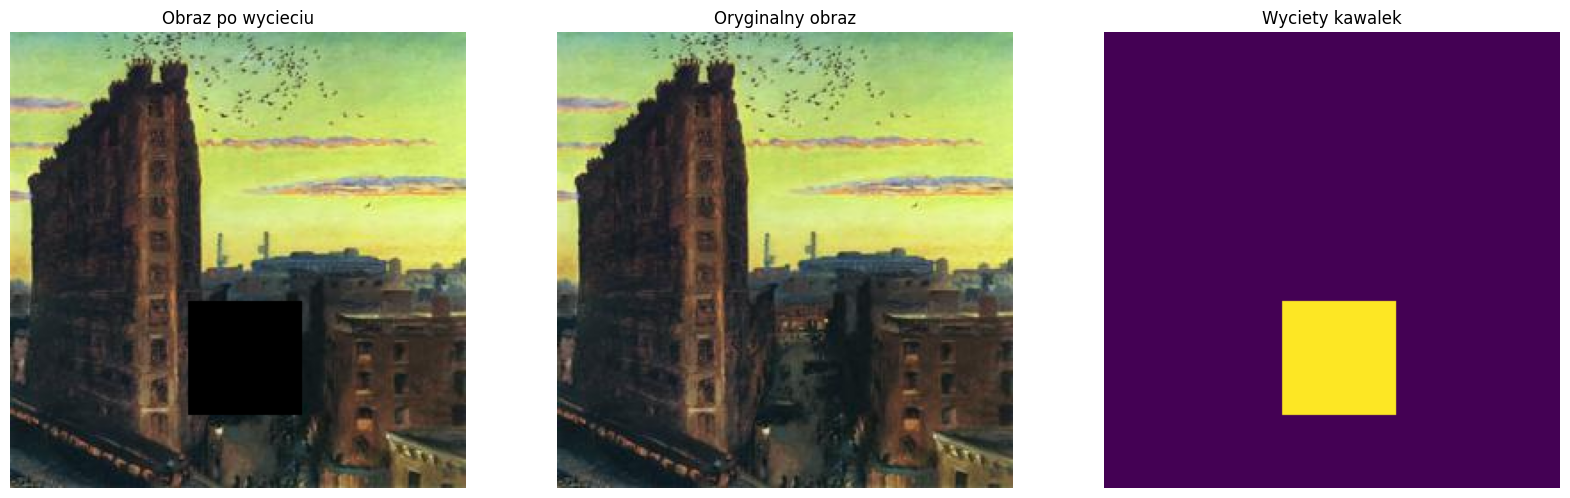

In [307]:
def regular_cut(images):
    BATCH, C, H, W = images.shape
    size_h, size_w = H // 4, W // 4
    
    starts = (torch.rand(BATCH, 2) * torch.tensor([H - size_h, W - size_w])).long()
    
    images_to_ret = images.clone()
    
    h_offsets = torch.arange(size_h).view(-1, 1)
    w_offsets = torch.arange(size_w).view(1, -1)
    
    h_indx = starts[:, 0].view(BATCH, 1, 1) + h_offsets
    w_indx = starts[:, 1].view(BATCH, 1, 1) + w_offsets
    
    images_to_ret[:, :-1, h_indx, w_indx] = 0.
    images_to_ret[:, -1, h_indx, w_indx] = 1.
    
    return images_to_ret


def irregular_cut(images):
    BATCH, _, H, W = images.shape
    num_points = (H * W) // 8 # 1/8 punktow zostanie usunieta z kazdego z obrazow, ale beda sie nachodzic i wyjdzie ok. 1/18
    
    centers = torch.rand(BATCH, 1, 2) * torch.tensor([H, W])  # (BATCH, 1, 2)
    
    scaling = H // 16
    offsets = torch.randn(BATCH, num_points, 2) * scaling  # (BATCH, num_points, 2)
    indices_to_cut = (offsets + centers).long() % torch.tensor([H, W])  # (BATCH, num_points, 2)
    
    images_to_ret = images.clone()
    
    h_indices = indices_to_cut[:, :, 0]  # (BATCH, num_points)
    w_indices = indices_to_cut[:, :, 1]  # (BATCH, num_points)

    images_to_ret[:, :-1, h_indices , w_indices] = 0.
    images_to_ret[:, -1, h_indices, w_indices] = 1.
    
    return images_to_ret


image_cut = regular_cut(images[0].unsqueeze(0)).permute(0, 2, 3, 1).squeeze()

# sprawdzenie czy wycinanie dziala - rysowanie tych obrazow
cut_layer = image_cut[:,:,-1].cpu().detach().numpy() # zobaczyc co sie wycielo
image_cut = (image_cut[:,:,:-1].cpu().detach().numpy() * 255).astype('uint8') # do numpy'a i skalowanie

fig, ((ax1, ax2, ax3)) = plt.subplots(ncols=3, nrows=1, figsize=(20, 15))

ax1.set_title('Obraz po wycieciu')
ax1.imshow(image_cut)
ax1.axis('off')

ax2.set_title('Oryginalny obraz')
ax2.imshow(np.array(image_refs[0]))
ax2.axis('off')

ax3.set_title('Wyciety kawalek')
ax3.imshow(cut_layer)
ax3.axis('off')

print(f'Czesc nieusunieta jest {cut_layer.size / cut_layer.sum() :.2f} razy wieksza od czesci usunietej.')

Oryginalny wymiar obrazu 256
Po 1 warstwie encodera rozmiar obrazu: 128
Po 3 warstwie encodera rozmiar obrazu: 64
Po 5 warstwie encodera rozmiar obrazu: 32
Po 7 warstwie encodera rozmiar obrazu: 16
Po 1 warstwie decodera rozmiar obrazu: 32
Po 3 warstwie decodera rozmiar obrazu: 64
Po 5 warstwie decodera rozmiar obrazu: 128
Po 7 warstwie decodera rozmiar obrazu: 256
100.00%

Text(0, 0.5, 'Blad')

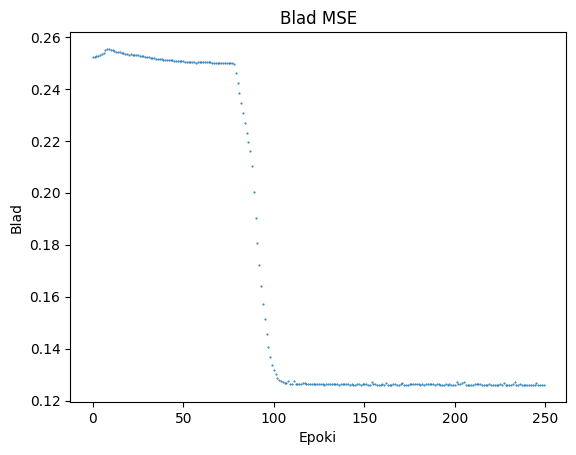

In [308]:
class Autoencoder(nn.Module):
    def __init__(self, image_shape, lr):
        super().__init__()
        
        kernel = 4
        padding = (kernel - 1) // 2
        channels = [image_shape[0], 16, 32, 16, 1]

        self.encode = nn.Sequential(   
            nn.Conv2d(channels[0], channels[1], kernel_size=kernel, stride=2, padding=padding), nn.ReLU(),
            nn.Conv2d(channels[1], channels[2], kernel_size=kernel, stride=2, padding=padding), nn.ReLU(),
            nn.Conv2d(channels[2], channels[3], kernel_size=kernel, stride=2, padding=padding), nn.ReLU(),
            nn.Conv2d(channels[3], channels[4], kernel_size=kernel, stride=2, padding=padding), nn.ReLU(),
        )
        self.decode = nn.Sequential(
            nn.ConvTranspose2d(channels[4], channels[3], kernel_size=kernel, stride=2, padding=padding), nn.ReLU(),
            nn.ConvTranspose2d(channels[3], channels[2], kernel_size=kernel, stride=2, padding=padding), nn.ReLU(),
            nn.ConvTranspose2d(channels[2], channels[1], kernel_size=kernel, stride=2, padding=padding), nn.ReLU(),
            nn.ConvTranspose2d(channels[1], channels[0], kernel_size=kernel, stride=2, padding=padding), nn.ReLU(),
        )
        
        # liczenie rozmiarow po convach - 
        w = image_shape[1] # obrazy maja takie same szerokosci i wysokosci
        print(f'Oryginalny wymiar obrazu {w}')
        for i, layer in enumerate(self.encode):
            if isinstance(layer, nn.Conv2d):
                w = (w - layer.kernel_size[0] + 2*layer.padding[0]) // layer.stride[0] + 1
                print(f'Po {i+1} warstwie encodera rozmiar obrazu: {w}')

        for i, layer, in enumerate(self.decode):
            if isinstance(layer, nn.ConvTranspose2d):
                w = (w - 1) * layer.stride[0] + layer.kernel_size[0] - 2*layer.padding[0]
                print(f'Po {i+1} warstwie decodera rozmiar obrazu: {w}')

        self.optim = torch.optim.Adam(self.parameters(), lr)
        self.loss = nn.MSELoss()

    def forward(self, input):
        return self.decode( self.encode(input) )
    
ENCODER_EPOCHS = 250
BATCH_SIZE = 128
autoencoder = Autoencoder(images.shape[1:], 2.5e-4)
loss_history = np.zeros(ENCODER_EPOCHS)

if torch.cuda.is_available():
    images = images.to('cuda')
    autoencoder = autoencoder.to('cuda')

# trenowanie encodera
for epoch in range(ENCODER_EPOCHS):
    print(f'\r{epoch / (ENCODER_EPOCHS - 1) * 100:.2f}%', end='', flush=True)
    for i in range(int(images.shape[0] / BATCH_SIZE)): # TODO na dataLoaderze to zrobic
        batch = images[i * BATCH_SIZE: (i+1) * BATCH_SIZE, :, : ,: ]
        if i % 4 == 1:
            batch = regular_cut(batch)
        elif i % 4 == 3:
            batch = irregular_cut(batch)
        autoencoder.zero_grad()
        image_reconstructed = autoencoder(batch)
        loss = autoencoder.loss(batch, image_reconstructed)
        loss.backward()
        autoencoder.optim.step()
        
        loss_history[epoch] = loss.item()

plt.title('Blad MSE')
plt.plot(loss_history, 'o', markersize=0.5)
plt.xlabel('Epoki')
plt.ylabel('Blad')

TypeError: tuple indices must be integers or slices, not tuple